In [73]:
%matplotlib inline
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'
from matplotlib import rc
rc('text', usetex=True)

from tqdm import tqdm

from PETITE.ryan_shower import Shower
from PETITE.particle import *
from PETITE.shower import Shower as OldShower
from PETITE.AllProcesses import *
from PETITE.kinematics import *

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfontBig=font0.copy()
legfontBig.set_size(18)
legfontBig.set_weight('bold')

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

Comparison: Electrons injected with equal energy to graphite using old/new prescription

In [74]:
MinEnergy = 0.080
sGraphite = Shower('/Users/kjkelly/Documents/GitHub/PETITE/RyanDicts/Feb7_', 'graphite', MinEnergy,neval=5000)
sGraphiteOld = OldShower('/Users/kjkelly/Documents/GitHub/PETITE/NBP/', 'graphite', MinEnergy)

In [103]:
Process = 'PairProd'
LUKey = 76

me =0.00051099895000 
alpha_FS =  1/137.035999084 

sample_list=sGraphite._loaded_samples 
Ee0 = sample_list[Process][LUKey][0]

# this grabs the dictionary part rather than the energy. 
sample_dict=sample_list[Process][LUKey][1]

integrand = sample_dict["integrator"]
max_F      = sample_dict["max_F"]*sGraphite._maxF_fudge_global
max_X      = sample_dict["max_X"]
max_wgt    = sample_dict["max_wgt"]

EvtInfo={'E_inc': Ee0, 'm_e': me, 'Z_T': sGraphite._ZTarget, 'alpha_FS': alpha_FS, 'm_V': 0}
diff_xsection_options={"PairProd" : dSPairProd_dP_T,
                        "Comp"     : dSCompton_dCT,
                        "Brem"     : dSBrem_dP_T,
                        "Ann"      : dAnn_dCT }

FF_dict              ={"PairProd" : G2el,
                        "Comp"     : Unity,
                        "Brem"     : G2el,
                        "Ann"      : Unity }

QSq_dict             ={"PairProd" : PPQSq, "Brem"     : BremQSq, "Comp": dummy, "Ann": dummy }


if Process in diff_xsection_options:
    diff_xsec_func = diff_xsection_options[Process]
    FF_func        = FF_dict[Process]
    QSq_func       = QSq_dict[Process]
else:
    raise Exception("Your process is not in the list")

AllEvts = []
for x, wgt in integrand.random():
    FF_eval=FF_func(EvtInfo['Z_T'], me, QSq_func(x, me, EvtInfo['E_inc'] ) )
    wgtA = wgt*diff_xsec_func(EvtInfo,x)*FF_eval
    AllEvts.append(np.concatenate([list(x), [wgtA]]))

In [104]:
AllEvtsOld = sGraphiteOld.get_PPSamples(LUKey)

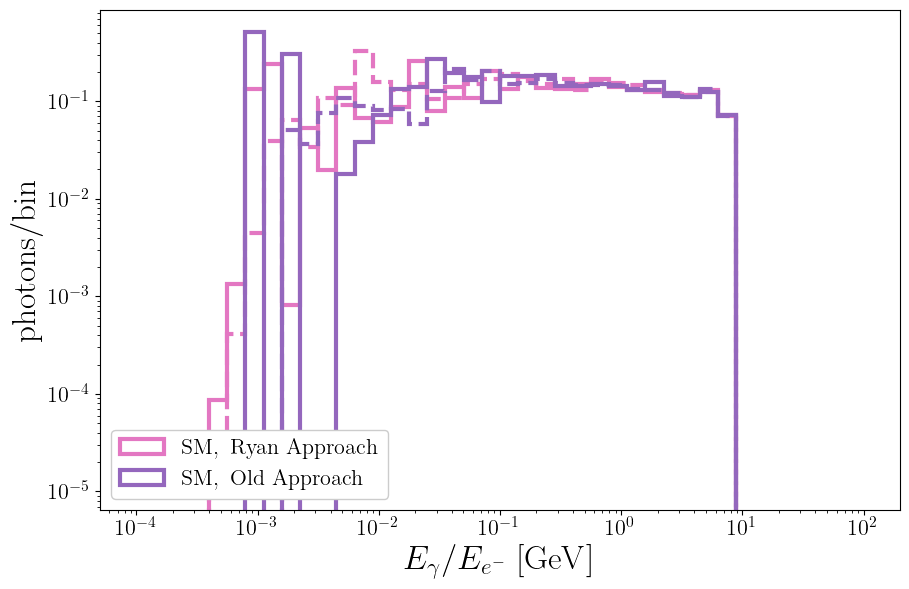

In [105]:
b0 = np.logspace(-4, 2, 41)
dens = True

plt.hist(np.transpose(AllEvts)[0], weights=len(AllEvtsOld)/np.sum(np.transpose(AllEvts)[-1])*np.transpose(AllEvts)[-1], bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-', label=r"$\mathrm{SM,\ Ryan\ Approach}$")
plt.hist(Ee0 - np.transpose(AllEvts)[0], weights=len(AllEvtsOld)/np.sum(np.transpose(AllEvts)[-1])*np.transpose(AllEvts)[-1], bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--')
plt.hist(np.transpose(AllEvtsOld)[0], bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='-', label=r"$\mathrm{SM,\ Old\ Approach}$")
plt.hist(Ee0 - np.transpose(AllEvtsOld)[0], bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='--')

plt.gca().legend(loc=3, fontsize=16, framealpha=1.0)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma/E_{e^-}\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-4,100,1e-1,1e4])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(8.0, 5.0)
